In [76]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline
import time
import sqlite3
import pandas as pd
from scipy.interpolate import interp1d

## Datas 
Zuwa, I started this part but please can you finc the distribution of those data depending on what we need for the problem + generate random data ?
You might also have to clean the data

In [67]:
DATA_PATH = '/Users/mathildebadoual/code/ecoblock_test/data/database.sqlite'

In [68]:
def import_load_demand(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT demand FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    load_demand = cur.fetchall()
    conn.close()
    return np.array(load_demand)

def import_ev_demand(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT ev_demand FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    ev_demand = cur.fetchall()
    conn.close()
    return np.array(ev_demand)

def import_pv_generation(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT pv_generation FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    pv_generation = cur.fetchall()
    conn.close()
    return np.array(pv_generation)

In [69]:
data = pd.read_csv('/Users/mathildebadoual/code/ev_controller/data/price_demand.csv')
data.max()

Year       2015.000
Month        12.000
day          31.000
Hour         24.000
Demand    23169.960
Price       187.891
dtype: float64

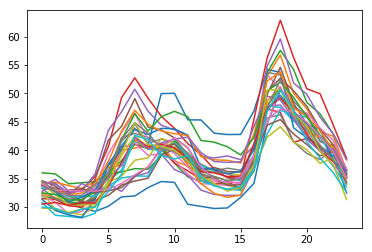

In [70]:
for day in range(1, 31):
    for month in range(1, 2):
        plt.plot(range(0, 24), data[(data['day'] == day) & (data['Month'] == month) & (data['Year'] == 2013)]['Price'])

## Regular Stochastic Control

In [123]:
## SET PARAMETERS
num_station = 2
ns = 10
ns_u = 3

c = 100
alpha = 0.03
alpha = 1
beta = 0.001
gamma = 1
u_max = 0.3
u_tot_max = 0.03
N = 2000 #depend on the lenght of the data

In [92]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
prices = prices_interp(np.linspace(0, 23, N))

In [124]:
SOC_grid = np.array(list(itertools.permutations(np.linspace(0, 1, ns), num_station)))

In [ ]:
## SOLVE DYNAMIC PROGRAM
start = time.time()

# Boundary Condition of Value Function (Principle of Optimality)
V[:, :, N] = np.zeros((num_station, ns * num_station))

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0, ns*num_station):

        # Find dominant bounds for u_batt
        lb = 
        ub = min(P_batt_max, P_dem[k], (SOC_grid[idx] - SOC_min) * Qcap * V_oc / Delta_t)
        
        # Grid Battery Power between dominant bounds
        u_batt_grid = np.array(list(itertools.permutations(np.linspace(lb, ub, ns_u), num_station)))
        #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
        # Cost of satisfaction
        satisfaction_k = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_grid[i, :])))/(1 - np.exp(alpha))) for i in range(SOC_grid.shape[0])])
        g_k = prices[k] * np.array([np.sum(u_batt_grid[:, i]) for i in range(SOC_grid.shape[0])]) + satisfaction_k
        
        # compute next SOC using dynamics
        SOC_nxt = SOC_grid[idx] - Delta_t * u_batt_grid
        
        # Compute value function at nxt time step (need to interpolate)
        V_nxt = interp(SOC_nxt.flatten(), SOC_grid.flatten(), V[:, :, k+1].flatten())
        
        # Value Function (Principle of Optimality)
           
        V[idx, k] = min(alph * Delta_t * g_k + V_nxt)
        ind = np.argmin(alph * Delta_t * g_k + V_nxt)
        
        # Save Optimal Control
        u_star[idx,k] = P_batt_grid[ind]
        
# DP Timer
end = time.time()
print(str(end - start) + " seconds")

## Stochastic Control

In [135]:
import itertools
x = itertools.permutations(np.linspace(0, u_max, ns), num_station)
y = np.array(list(x))

In [138]:
np.array([np.sum(y[i, :]) for i in range(y.shape[0])]).shape

(90,)

In [139]:
A = np.array([[1, 2, 3], [1, 2, 3]])
np.squeeze(A)

array([[1, 2, 3],
       [1, 2, 3]])

In [140]:
A.flatten()

array([1, 2, 3, 1, 2, 3])